$$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
\newcommand{\braket}[1]{\langle | {#1} | \rangle}
$$

# Evolução de um Qubit com Hamiltoniano Dependente do Tempo e Canal de Amortecimento de Amplitude

## Introdução

Neste exemplo, ilustro como simular a evolução temporal de um qubit sujeito a um Hamiltoniano dependente do tempo e a um canal de amortecimento de amplitude. 

O Hamiltoniano contém um termo constante $\sigma_x$ e um termo dependente do tempo $\sigma_z$, permitindo estudar os efeitos de um campo magnético variável sobre o estado do qubit. O canal de amortecimento de amplitude modela a perda de energia do qubit para o seu ambiente, uma ocorrência comum em sistemas quânticos reais.

## Hamiltoniano

O Hamiltoniano total do sistema é dado por

$$
H(t) = H_0 + H_1(t),
$$

onde $H_0 = J \sigma_x$ é um termo constante que acopla os estados $\ket{0}$ e $\ket{1}$, e $H_1(t) = \Delta(t) \sigma_z$ é um termo dependente do tempo que descreve a interação do qubit com um campo magnético externo variável na direção $z$. A função $\Delta(t)$ varia linearmente com o tempo como

$$
\Delta(t) = \frac{\Delta_{\tau} - \Delta_0}{\tau} t + \Delta_0,
$$

onde $\Delta_0$ é a intensidade inicial do campo magnético, $\Delta_{\tau}$ é a intensidade final do campo magnético, e $\tau$ é o tempo total de evolução. Essa dependência linear no tempo nos permite estudar a mudança gradual da influência do campo magnético no qubit.

## Canal de Amortecimento de Amplitude

O amortecimento de amplitude é um tipo comum de ruído em sistemas quânticos, representando a dissipação de energia. Neste caso, modelamos o amortecimento de amplitude como um processo de salto quântico usando operadores de Kraus. Os dois operadores de Kraus $K_0$ e $K_1$ descrevem os processos de não salto e salto, respectivamente:

$$
K_0 = \begin{pmatrix} 1 & 0 \\ 0 & \sqrt{1-p} \end{pmatrix}, \quad K_1 = \begin{pmatrix} 0 & \sqrt{p} \\ 0 & 0 \end{pmatrix}.
$$

Aqui, $p$ é a probabilidade de amortecimento, que determina a probabilidade de o sistema sofrer um salto quântico, levando à perda de energia do estado excitado $\ket{1}$ para o estado fundamental $\ket{0}$.



## Dinâmica via Lindblad 

Vimos em aula que a equação de Lindblad permite descrever a evolução de sistemas quânticos abertos, levando em conta tanto a evolução unitária devido ao Hamiltoniano quanto os efeitos dissipativos. No contexto deste modelo, a equação de Lindblad para o qubit sujeito ao Hamiltoniano dependente do tempo $H(t)$ e ao canal de amortecimento de amplitude com operadores de salto $K_0$ e $K_1$ pode ser escrita da seguinte forma:

$$
\frac{d\rho(t)}{dt} = -i \left[ H(t), \rho(t) \right] + \sum_{j} \left( K_j \rho(t) K_j^\dagger - \frac{1}{2} \{ K_j^\dagger K_j, \rho(t) \} \right),
$$

onde:

- $\rho(t)$ é a matriz densidade do qubit no instante de tempo $t$,
- $H(t)$ é o Hamiltoniano dependente do tempo dado por $H(t) = J \sigma_x + \Delta(t) \sigma_z$, com $\Delta(t)$ variando linearmente com o tempo,
- $K_j$ são os operadores de salto (neste caso $K_0$ e $K_1$) que descrevem os efeitos dissipativos.

### Liouvilliano

1. **Evolução unitária**: $ -i [H(t), \rho(t)] $ representa a evolução do sistema de acordo com o Hamiltoniano $H(t)$, onde o termo de comutador capta a dinâmica unitária do sistema.

2. **Efeito dissipativo**: O termo $\sum_j \left( K_j \rho(t) K_j^\dagger - \frac{1}{2} \{ K_j^\dagger K_j, \rho(t) \} \right)$ descreve os efeitos não-unitários causados pela interação com o ambiente, que neste caso é o canal de amortecimento de amplitude. 






A seguir, encontra-se o código que modela esse processo com o QuTip.


In [12]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import cm  # Colormaps used for mapping values to colors
import matplotlib as mpl  # General matplotlib functions

In [2]:
import enum
from urllib.parse import quote_from_bytes
import numpy as np
import os, sys


# Insert the custom module's path into system path
sys.path.insert(0, f"{os.path.expanduser('~')}/Dropbox/my_py_modules/graphs_and_animations")
from add_latex import *  # Custom LaTeX module for rendering LaTeX equations in plots


from qutip import *  # Import QuTiP for working with quantum objects and simulations

# Function to generate time-dependent Hamiltonian term Delta(t)
def Delta_t(t, args):
    Delta_0 = args['Delta_0']  # Initial value of Delta
    Delta_tau = args['Delta_tau']  # Final value of Delta at time tau
    tau = args['tau']  # Total evolution time
    
    # Linear interpolation of Delta between Delta_0 and Delta_tau
    return (Delta_tau - Delta_0) * t / tau + Delta_0

# Function to compute the Bloch vector components (rx, ry, rz) from a density matrix
def qubit_Bloch_vector_from_density_matrix(rho):
    rx = 2*rho[0,1].real  # x-component of the Bloch vector (real part of off-diagonal)
    ry = -2*rho[0,1].imag  # y-component of the Bloch vector (imaginary part of off-diagonal)
    rz = 2*rho[0,0].real-1  # z-component of the Bloch vector (diagonal elements)
    return rx, ry, rz

Os parâmetros considerados no sistema estão abaixo.

In [3]:
# Parameters for the system evolution
J = 0.5  # Coupling constant for sigma_x term in the Hamiltonian
hz = -1.0  # Z-direction field strength
tau = 10  # Total evolution time
p = 0.1  # Amplitude damping parameter
nts = 101  # Number of time steps for the evolution
tlist = np.linspace(0, tau, nts)  # List of times for the evolution

# Arguments for the time-dependent Hamiltonian
H_args = {'Delta_0': -0.5*hz, 'Delta_tau': hz, 'tau': tau}

# Define the time-independent and time-dependent parts of the Hamiltonian
H_0 = J * sigmax()  # Time-independent sigma_x term
H_1 = sigmaz()  # Time-dependent sigma_z term

# Combine the Hamiltonian terms into a time-dependent Hamiltonian
H_td = [H_0, [H_1, Delta_t]]

# Define amplitude damping (Kraus) operators
K_0 = np.array([[1, 0], [0, np.sqrt(1-p)]])  # Operator for no excitation loss
K_1 = np.array([[0, np.sqrt(p)], [0, 0]])  # Operator for amplitude damping
K_ops = [Qobj(K_0), Qobj(K_1)]  # Convert to QuTiP quantum objects

# Initial state of the system (a mixed state with probability p_0 in |0⟩)
p_0 = 0.9
rho_0 = Qobj(np.array([[p_0, 0], [0, 1-p_0]]))  # Initial density matrix




In [4]:
# Evolve the system using the Lindblad master equation
rho_ts = mesolve(H_td, rho_0, tlist=tlist, args=H_args, c_ops=K_ops, e_ops=[]).states


## Perda de pureza

O estado inicial do qubit é escolhido como um estado misto, com uma probabilidade de população $p_0 = 0.9$ no estado fundamental $\ket{0}$. A evolução do sistema é simulada usando a função ```mesolve``` do QuTiP, que resolve a equação mestra de Lindblad para sistemas quânticos abertos. A pureza do estado do qubit em cada intervalo de tempo é calculada como

$$
P(t) = \text{Tr}(\rho^2),
$$

onde $P(t)$ varia de 1 para um estado puro a 0.5 para um estado maximamente misto. A mudança na pureza é usada para colorir os pontos na esfera de Bloch, onde maiores purezas são representadas por cores mais intensas.

A evolução temporal é visualizada plotando os estados inicial e final na esfera de Bloch, com anotações indicando o estado inicial $\hat{\rho}_0$ e o estado final $\hat{\rho}_{\tau}$. Os pontos que representam estados intermediários são coloridos de acordo com sua pureza, proporcionando uma visão clara de como o qubit evolui sob a influência combinada do Hamiltoniano dependente do tempo e do canal de amortecimento de amplitude.

In [5]:
# Prepare to store results for Bloch vector evolution
P_ts = np.zeros(nts)  # Purity of the state at each time step
pts = []  # List of Bloch vector components at each time step

# Loop over all time steps to compute the Bloch vectors and purities
for it, t in enumerate(tlist):
    rho_t = rho_ts[it]  # Get density matrix at time t
    rx, ry, rz = qubit_Bloch_vector_from_density_matrix(rho_t)  # Compute Bloch vector
    P = rho_t.purity()  # Compute the purity of the state at time t
    P_ts[it] = P  # Store purity value
    pts.append([rx, ry, rz])  # Store Bloch vector components






Utilizamos um mapa de cor tal que cores vermelhas indicam maior pureza, enquanto cores roxas indicam perda de pureza. 


In [6]:
# Normalize purity values and create a colormap based on purity
norm = mpl.colors.Normalize(vmin=P_ts.min(), vmax=P_ts.max())  # Normalize purity values
cmap = cm.rainbow  # Use rainbow colormap
m = cm.ScalarMappable(norm=norm, cmap=cmap)  # Create a scalar mappable to convert purities to colors

# Map purity values to colors for the points on the Bloch sphere
cores = [m.to_rgba(P) for P in P_ts]



## Visualização na Esfera de Bloch

Podemos visualizar a dinâmica do qubit na esfera de Bloch, onde cada ponto na esfera corresponde a um estado quântico único. Um estado puro encontra-se na superfície da esfera, enquanto os estados mistos encontram-se dentro dela. Efeitos de dissipação aparecerão quando há interação com o ambiente que promove decoerência. 

Para visualizar a evolução do qubit, plotamos o vetor de Bloch $\vec{r} = (r_x, r_y, r_z)$ em cada intervalo de tempo. Os componentes do vetor de Bloch são derivados da matriz densidade $\rho$ da seguinte forma:

$$
r_x = 2 \Re(\rho_{01}), \quad r_y = -2 \Im(\rho_{01}), \quad r_z = 2 \rho_{00} - 1.
$$

À medida que o qubit evolui sob a influência do Hamiltoniano dependente do tempo e do canal de amortecimento de amplitude, o vetor de Bloch muda de forma correspondente, movendo-se em direção ao centro da esfera à medida que o estado se torna mais misto devido à dissipação de energia.

<IPython.core.display.Javascript object>


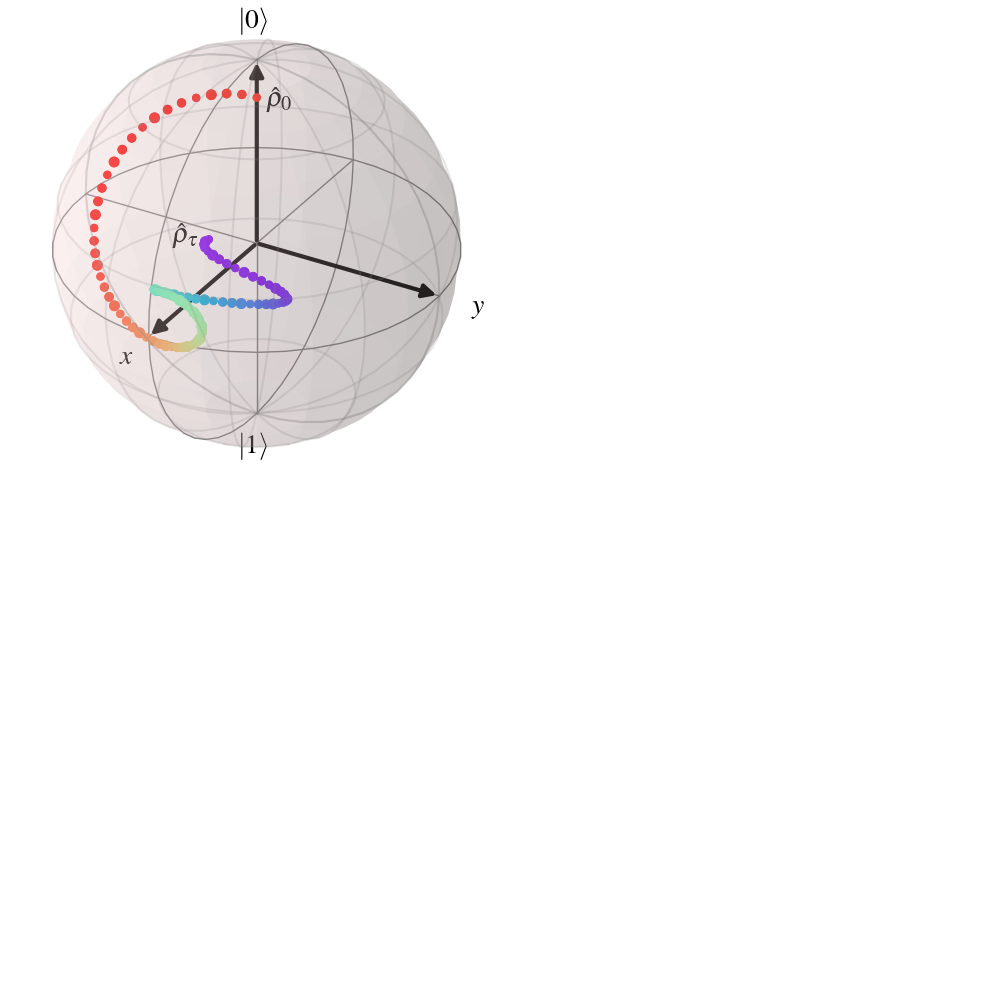

<IPython.core.display.Javascript object>

In [8]:
# Initialize Bloch sphere visualization
b = Bloch()

# Add basis vectors to the Bloch sphere (x, y, z axes)
b.vector_color = ['k']  # Black color for basis vectors
b.add_vectors([1,0,0])  # x-axis vector
b.add_vectors([0,1,0])  # y-axis vector
b.add_vectors([0,0,1])  # z-axis vector

b.point_color = cores  # Set point colors based on purity
b.point_marker = ['o']  # Use circular markers for points

# Add points to the Bloch sphere, representing the state evolution
for pt in pts:
    b.add_points(pt)

# Add annotation for the initial state
b.add_annotation([pts[0][0], pts[0][1]+0.05, pts[0][2]], r'$\quad \quad \quad \quad  \hat{\rho}_0$', ha='left')

# Add annotation for the final state
b.add_annotation([pts[-1][0], pts[-1][1]-0.075, pts[-1][2]], r'$\hat{\rho}_\tau \quad \quad \quad \quad \quad  $', ha='right')

# Render the Bloch sphere with the points and vectors
b.render()
b.show()

# Save the Bloch sphere image to a file
plt.savefig('qubit_amplitude_damping.png', transparent=True)

# Show the plot
plt.show()